#Imports

Common imports (needed for all models) also needed if you want also use the **first** model:

In [ ]:
from datetime import datetime

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import os
from PIL import Image
import pathlib
from keras.applications.mobilenet import preprocess_input
import json
from pickle import load
import pickle
from nltk.translate.bleu_score import corpus_bleu
from keras.preprocessing.text import Tokenizer
from numpy import argmax
from keras.models import load_model

Imports needed if you want also use the **second** model:

In [ ]:
from tensorflow.keras import datasets, layers, models

Imports needed if you want also use the **third** model:

In [ ]:
!pip install torch transformers evaluate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [ ]:
import urllib.parse as parse
import requests
import torch
from transformers import *
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
from datasets import Dataset
from datasets import load_from_disk
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter
# set device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
import evaluate

This python notebook was made to be run in Colab, so let's mount drive:

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#Loading dataset

Let's download the Flicker8k dataset:

In [ ]:
tf.keras.utils.get_file(
    origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
    cache_dir='.',
    extract=True)

1115419746/1115419746 [==============================] - 10s 0us/step


'./datasets/Flickr8k_Dataset.zip'

In [ ]:
tf.keras.utils.get_file(
    origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
    cache_dir='.',
    extract=True)

2340801/2340801 [==============================] - 1s 0us/step


'./datasets/Flickr8k_text.zip'

#First Model: VGG16-RNN

##Preprocess data

Let's prepare the data for the model: we need to clean the descriptions, resize the images and check if they all have 3 channels.

###Images

Let's extract the features of the images using the pretrained VGG16 model:

In [ ]:
# extract features from each photo in the directory
def extract_features(directory):
  # load the model
  model = keras.applications.vgg16.VGG16()
  # re-structure the model
  model = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
  # summarize
  print(model.summary())
  # extract features from each photo
  features = dict()
  # Iterate over images in the directory
  for name in os.listdir(directory):
    # Load an image from file
    filename = directory + '/' + name
    image = Image.open(filename)
    # Resize the image to (224, 224)
    image = image.resize((224, 224))
    # Convert the image pixels to a numpy array
    image = keras.utils.img_to_array(image)
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Prepare the image for the VGG model
    image = preprocess_input(image)
    # Get features
    feature = model.predict(image, verbose=0)
    # Get image id
    image_id = name.split('.')[0]
    # Store feature
    features[image_id] = feature
  return features

Let's call the function and extract the features using the previous function:

In [ ]:
# Path to the directory containing images
directory = '/content/datasets/Flicker8k_Dataset'
features = extract_features(directory)

Let's save the features extracted to a file "features.pkl":

In [ ]:
# Save the dictionary to a file
with open("features.pkl", "wb") as file:
    pickle.dump(features, file)

###Descriptions

This function will load the files we need:

In [ ]:
# load doc into memory
def load_doc(filename):
 # open the file as read only
 file = open(filename, 'r')
 # read all text
 text = file.read()
 # close the file
 file.close()
 return text

With the above function, let's load all the descriptions:

In [ ]:
directory = '/content/datasets/Flickr8k.token.txt'

# load descriptions
doc = load_doc(directory)

Now let's define a function that maps all the images to its description (the return will be a dictionary with the name of image as keys and a list of words (the descriptions) as values):

In [ ]:
# extract descriptions for images
def load_descriptions(doc):
  mapping = dict()
  # process lines
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]
    # remove filename from image id
    image_id = image_id.split('.')[0]
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    # create the list if needed
    if image_id not in mapping:
      mapping[image_id] = list()
    # store description
    mapping[image_id].append(image_desc)
  return mapping

In [ ]:
# parse descriptions
descriptions = load_descriptions(doc)

Let's remove punctuation, letter in uppercase and numbers:

In [ ]:
import string

def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove hanging 's' and 'a'
      desc = [word for word in desc if len(word)>1]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] =  ' '.join(desc)

In [ ]:
# clean descriptions
clean_descriptions(descriptions)

Let's build a list of all description strings

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
  # build a list of all description strings
  all_desc = set()
  for key in descriptions.keys():
    [all_desc.update(d.split()) for d in descriptions[key]]

  return all_desc

In [ ]:
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)

Just like the features previously, let's save the descriptions in a file "description.txt":

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
 lines = list()
 for key, desc_list in descriptions.items():
  for desc in desc_list:
    lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()

In [ ]:
# save descriptions
save_descriptions(descriptions, 'descriptions.txt')

##Model

###Load training set and tokenize descriptions

Let's define the fuctions to load the dataset, images, features and descriptions:

In [ ]:
# load a pre-defined list of photo identifiers
def load_set_test(filename):
  doc = load_doc(filename)
  dataset = list()
  c = 0
  # process line by line
  for line in doc.split('\n'):
    c=c+1
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
    if (c == 100):
      break
  print(c)
  return set(dataset)

# load a pre-defined list of photo identifiers
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  c = 0
  # process line by line
  for line in doc.split('\n'):
    c=c+1
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
    if (c == 3000):
      break
  print(c)
  return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
  # load all features
  with open(filename , 'rb') as f:
    all_features = pickle.load(f)
  #all_features = load(open(filename, 'rb'))
  # filter features
  features = {k: all_features[k] for k in dataset}
  return features


Let's load the training set:

In [ ]:
# load training dataset (6K)
filename = '/content/datasets/Flickr_8k.trainImages.txt'
train = load_set(filename)

# descriptions
train_descriptions = load_clean_descriptions('/content/descriptions.txt', train)

# photo features
train_features = load_photo_features('/content/features.pkl', train)


3000


In [ ]:
train1=train_features

Let's tokenize the train descrpitions:

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = keras.preprocessing.text.Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [ ]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

In the end let's compute the length of the description with the most words:

In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [ ]:
max_length = max_length(descriptions)

####Load the test set

In [ ]:
# load test set
filename = '/content/datasets/Flickr_8k.testImages.txt'
test = load_set(filename)

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)

# photo features
test_features = load_photo_features('features.pkl', test)

1001


In [ ]:
test_features1=test_features

###Model and training

Let's define a function create_sequences(), given the tokenizer, a maximum sequence length, and the dictionary of all descriptions and photos, will transform the data into input-output pairs of data for training the model.

In [ ]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = tf.keras.utils.pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [in_img, in_seq], out_word

Let's define the model, it can be described in three parts:
*   Feature extractor model: that takes in input the features we extracted previously
*   Sequence model: this part will take care of the text input
*   Decoder model: merges both the previous model and feeds the output to the final Dense layers



In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = tf.keras.layers.Input(shape=(4096,))
	fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
	fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = tf.keras.layers.Input(shape=(max_length,))
	se1 = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = tf.keras.layers.Dropout(0.5)(se1)
	se3 = tf.keras.layers.LSTM(256)(se2)
	# decoder model
	decoder1 = tf.keras.layers.add([fe2, se3])
	decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
	outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	return model

In [ ]:
model1 = define_model(vocab_size, max_length)

Let's use the fit_generator() function on the model to train the model with this data generator.

In [ ]:
start_time = datetime.now()

In [ ]:
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	model1.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model1.save('model_' + str(i) + '.h5')

<ipython-input-34-937ef056e903>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


3000/3000 [==============================] - 484s 158ms/step - loss: 4.8353


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3000/3000 [==============================] - 358s 119ms/step - loss: 2.3210


In [ ]:
end_time = datetime.now()
total_time = end_time - start_time

In [ ]:
print('Duration: {}'.format(total_time))

Duration: 2:03:02.478157


###Evaluation

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

The function generate_desc() generates a textual description given a trained model, and a given prepared photo as input.

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

The function below named evaluate_model() will evaluate a trained model against a given dataset of photo descriptions and photo features. The actual and predicted descriptions are collected and evaluated collectively using the corpus BLEU score that summarizes how close the generated text is to the expected text.

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# load the model
filename = 'model_19.h5' #if we don't change the paramenters 19 should be the last model
model1 = load_model(filename)

In [ ]:
# evaluate model
evaluate_model(model1, test_descriptions, test_features, tokenizer1, max_length)

BLEU-1: 0.381853
BLEU-2: 0.143033
BLEU-3: 0.081471
BLEU-4: 0.030008


In [ ]:
#change name to avoid confusion from other models when we want to show the results
tokenizer1=tokenizer

#Second Model: CNN-RNN

In this model we will extract the image features using CNN instead of a pretrained model.

The second part of the model that manages the language will remain unchanged, supporting a LSTM-based model.

We will use most of the functions already defined in the previous model.

####Preprocess data

We can use the same code as for the previous model, if already run once there's no need to repeat the process.

####Model definition and features extraction

Let's define the model, to make our life easier we will make the shape of the input equal to the VGG16:

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.InputLayer(input_shape = (224, 224, 3)))
model.add(layers.Conv2D(64, (1, 1), activation='relu'))
model.add(layers.Conv2D(64, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (1, 1), activation='relu'))
model.add(layers.Conv2D(128, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (1, 1), activation='relu'))
model.add(layers.Conv2D(256, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (1, 1), activation='relu'))
model.add(layers.Conv2D(512, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (1, 1), activation='relu'))
model.add(layers.Conv2D(512, (1, 1), activation='relu'))
model.add(layers.Conv2D(512, (1, 1), activation='relu'))
model.add(layers.Conv2D(512, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(3))

Let's change our function extract_features(directory) so that uses our new model instead of VGG16:

In [ ]:
# extract features from each photo in the directory
def extract_features_model(directory):
  # extract features from each photo
  features = dict()
  # Iterate over images in the directory
  for name in os.listdir(directory):
    # Load an image from file
    filename = directory + '/' + name
    image = Image.open(filename)
    # Resize the image to (224, 224)
    image = image.resize((224, 224))
    # Convert the image pixels to a numpy array
    image = keras.utils.img_to_array(image)
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Prepare the image for the VGG model
    image = preprocess_input(image)
    # Get features
    feature = model.predict(image, verbose=0)
    # Get image id
    image_id = name.split('.')[0]
    # Store feature
    features[image_id] = feature
  return features

In [ ]:
# Path to the directory containing images
directory = '/content/datasets/Flicker8k_Dataset'
features = extract_features_model(directory)

Just like in the previous model let's save the features in a file:

In [ ]:
# Save the dictionary to a file
with open("features_model2.pkl", "wb") as file:
    pickle.dump(features, file)

In [ ]:
# load training dataset (6K)
filename = '/content/datasets/Flickr_8k.trainImages.txt'
train = load_set(filename)

# photo features
train_features = load_photo_features('/content/features_model2.pkl', train)

# descriptions
train_descriptions = load_clean_descriptions('/content/descriptions.txt', train)

3000


In [ ]:
#change name to avoid confusion from other models when we want to show the results
train2=train_features

Let's use the model previously used to merge and add an lstm for the text, but this time with our new extracted features:

In [ ]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = tf.keras.layers.Input(shape=(3,))
	fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
	fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = tf.keras.layers.Input(shape=(max_length,))
	se1 = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = tf.keras.layers.Dropout(0.5)(se1)
	se3 = tf.keras.layers.LSTM(256)(se2)
	# decoder model
	decoder1 = tf.keras.layers.add([fe2, se3])
	decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
	outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [ ]:
model2 = define_model(vocab_size, max_length)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 32, 256)              1401856   ['input_7[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 3)                    0         ['input_6[0][0]']             
                                                                                            

In [ ]:
start_time = datetime.now()

In [ ]:
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	model2.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model2.save('second_model_' + str(i) + '.h5')

   1/3000 [..............................] - ETA: 4:39 - loss: 4.2144

<ipython-input-61-fba893c2d6c2>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


3000/3000 [==============================] - 348s 116ms/step - loss: 2.7461


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3000/3000 [==============================] - 338s 113ms/step - loss: 2.1369


In [ ]:
end_time = datetime.now()
total_time = end_time - start_time

In [ ]:
print('Duration: {}'.format(total_time))

Duration: 2:02:17.897424


####Evalutation

Again, we can re-use the previously defined function to evaluate the model:

In [ ]:
# load test set
filename = '/content/datasets/Flickr_8k.testImages.txt'
test = load_set(filename)

# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)

# photo features
test_features = load_photo_features('features_model2.pkl', test)

1001


In [ ]:
# load the model
filename = '/content/second_model_19.h5'
model = load_model(filename)

In [ ]:
# evaluate model
evaluate_model(model2, test_descriptions, test_features, tokenizer1, max_length)

BLEU-1: 0.368262
BLEU-2: 0.123261
BLEU-3: 0.060637
BLEU-4: 0.019978


In [ ]:
#change name to avoid confusion from other models when we want to show the results
tokenizer2=tokenizer
test_features2=test_features

#Third Model: Transformer

##Preprocess data

Since we are going to use pytorch for transformers, Hugging face library for dataset type, we need to preprocess and convert our data into a dataset type.

TensorFlow also has transformers, but Pytorch has better performance and are more intuitive.

In [ ]:
# convert each image and caption in a dictionary to convert in dataset
def convert_into_dataset(directory, descriptions):
  counter_id_sentences=0
  counter_id_images=0
  table = str.maketrans('', '', string.punctuation)
  features_dict = dict()
  data = defaultdict(list)
  # Iterate over images in the directory
  for name in os.listdir(directory):
    #Set up counters as unique keys for images
    counter_id_images=counter_id_images+1
    # Load an image from filename and filepath
    filename = directory + '/' + name
    # Get image id
    image_id = name.split('.')[0]
    desc_list=descriptions[image_id]
    sentences_id=[]
    dict_sentences=[]
    for i in range(len(desc_list)):
      descr_dict = dict()
      counter_id_sentences=counter_id_sentences+1
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove hanging 's' and 'a'
      desc = [word for word in desc if len(word)>1]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] =  ' '.join(desc)
      descr_dict['tokens']=desc
      descr_dict['raw']=desc_list[i]
      descr_dict['imgid']=counter_id_images
      descr_dict['sentid']=counter_id_sentences
      sentences_id.append(counter_id_sentences)
      dict_sentences.append(descr_dict)

    image = Image.open(filename)
    for caption in dict_sentences:
      data['filepath'].append(filename)
      data['sentid'].append(sentences_id)
      data['filename'].append(name)
      data['sentences'].append(caption)
      data['image'].append(image)
      data['imgid'].append(counter_id_images)
      features_dict = dict()
      features_dict['filepath']=filename
      features_dict['image']=image
      features_dict['sentid']=sentences_id
      features_dict['filename']=name
      features_dict['sentences']=caption
      features_dict['imgid']=counter_id_images
      features.append(features_dict)

  return data

In [ ]:
directory = '/content/datasets/Flicker8k_Dataset'
dataset = convert_into_dataset(directory, descriptions)
dataset_transformer = Dataset.from_dict(dataset)

Let's save our result:

In [ ]:
dataset_transformer.save_to_disk("/content/dataset_transformer")

###Model

Let's choose our encoder-decoder models, in this case we used:
*   Encoder: swin-base-patch4-window7-224-in22k
*   Decoder: gpt2

Other choises for encoder could have been:
```
encoder_model = "WinKawaks/vit-small-patch16-224"
encoder_model = "google/vit-base-patch16-224"
encoder_model = "google/vit-base-patch16-224-in21k"
```

Other choises for decoder could have been:
```
decoder_model = "bert-base-uncased"
decoder_model = "prajjwal1/bert-tiny"
```



In [ ]:
# the encoder model that process the image and return the image features
encoder_model = "microsoft/swin-base-patch4-window7-224-in22k"
# the decoder model that process the image features and generate the caption
decoder_model = "gpt2"
# load the model
model3 = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder_model, decoder_model
).to(device)

Output streaming troncato alle ultime 5000 righe.
    "rose_window, rosette": 9916,
    "roseate_spoonbill, Ajaia_ajaja": 1912,
    "rosebay, Rhododendron_maxima": 19033,
    "rosebud": 17526,
    "rosebud_cherry, winter_flowering_cherry, Prunus_subhirtella": 20120,
    "rosebud_orchid, Cleistes_rosea, Pogonia_rosea": 18520,
    "rosefish, ocean_perch, Sebastodes_marinus": 4079,
    "roselle, rozelle, sorrel, red_sorrel, Jamaica_sorrel, Hibiscus_sabdariffa": 18887,
    "rosemary": 13339,
    "rosemary, Rosmarinus_officinalis": 20711,
    "rosewood, rosewood_tree": 19778,
    "rosilla, Helenium_puberulum": 18324,
    "rosin_bag": 9917,
    "rosinweed, Silphium_laciniatum": 18422,
    "rosita, Centaurium_calycosum": 19186,
    "rosy_boa, Lichanura_trivirgata": 1199,
    "rotary_actuator, positioner": 9918,
    "rotary_engine": 9919,
    "rotary_press": 9920,
    "rotating_mechanism": 9921,
    "rotating_shaft, shaft": 9922,
    "rotavirus": 258,
    "rotgut": 13998,
    "rotifer": 1728,


loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--microsoft--swin-base-patch4-window7-224-in22k/snapshots/68dc76680a5bf3bdf670669f3025dc9be2e30781/model.safetensors
Some weights of the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of SwinModel were initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k.
If your task is similar to the task the model of the

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_vers

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/model.safetensors
Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "transformers_version": "4.33.1"
}

All model checkpoint weights were used when initializing GPT2LMHeadModel.

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.10.crossattention.c_attn.bias', 'h.3.ln_cross_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.7.crossattention.q_attn.bias', 'h.11.crossattention.c_proj.weight', 'h.8.ln_cross_attn.weight', 'h.6.ln_cross_attn.bias', 'h.4.crossattention.c_attn.weight', 'h.9.crossattention.q_attn.bias', 'h.4.crossattention.c_attn.bias', 'h.2.crossattention.c_proj.weight', 'h.4.crossattention.c_proj.bias', 'h.11.crossattention.c_attn.bias', 'h.8.crossattention.c_proj.weight', 'h.10.crossattention.c_pr

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/generation_config.json
Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "transformers_version": "4.33.1"
}

Setting `config.is_decoder=True` and `config.add_cross_attention=True` for decoder_config
Generate config GenerationConfig {
  "_from_model_config": true,
  "transformers_version": "4.33.1"
}



In [ ]:
# initialize the tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained(decoder_model)
# load the image processor
image_processor = ViTImageProcessor.from_pretrained(encoder_model)

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gpt2/snapshots/11c5a3d5811f50298f278a704980280950aedb10/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_ran

In [ ]:
# gpt2 does not have decoder_start_token_id and pad_token_id
# but has bos_token_id and eos_token_id
tokenizer.pad_token = tokenizer.eos_token # pad_token_id as eos_token_id
model3.config.eos_token_id = tokenizer.eos_token_id
model3.config.pad_token_id = tokenizer.pad_token_id
# set decoder_start_token_id as bos_token_id
model3.config.decoder_start_token_id = tokenizer.bos_token_id

Let's load our preprosessed data we saved: (optional if we just run the function that preprocess our dataset)

In [ ]:
dataset_transformer = load_from_disk("/content/dataset_transformer")

Let's split our data in training, test and validation set:

In [ ]:
train_dataset=dataset_transformer
train = train_dataset.train_test_split(test_size=0.1)
train_dataset = train['train']
test_dataset = train['test']
train=train['train'].train_test_split(test_size=0.1)
train_dataset=train['train']
val_dataset=train['test']

def preprocess(items):
  # preprocess the image
  pixel_values = image_processor(items["image"], return_tensors="pt").pixel_values.to(device)
  # tokenize the caption with truncation and padding
  targets = tokenizer([ sentence["raw"] for sentence in items["sentences"] ],
                      max_length=max_length, padding="max_length", truncation=True, return_tensors="pt").to(device)
  return {'pixel_values': pixel_values, 'labels': targets["input_ids"]}

# using with_transform to preprocess the dataset during training
train_dataset = train_dataset.with_transform(preprocess)
valid_dataset = val_dataset.with_transform(preprocess)
test_dataset  = test_dataset.with_transform(preprocess)

We will pass the collate_fn() callback to our data loader before we start training.

In [ ]:
# a function we'll use to collate the batches
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch])
    }

In [ ]:
num_epochs = 2 # number of epochs
batch_size = 16 # the size of batches
max_length = 32 # max length of the captions in tokens

Let's wrap our training, validation, and testing sets as data loaders:

In [ ]:
# training pytorch loop
# define our data loaders
train_dataset_loader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
valid_dataset_loader = DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=8, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=8, shuffle=True)

Let's define the optimizer:

In [ ]:
# define the optimizer
optimizer = AdamW(model3.parameters(), lr=1e-5)

###Training

Let's define a function that will compute the bleu score while training:

In [ ]:
# load bleu metrics
bleu = evaluate.load("bleu")

def compute_metrics(eval_pred):
  preds = eval_pred.label_ids
  labels = eval_pred.predictions
  # decode the predictions and labels
  pred_str = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
  # compute the bleu score
  bleu_result = bleu.compute(predictions=pred_str, references=labels_str)
  # get the length of the generated captions
  generation_length = bleu_result["translation_length"]
  return {
        "bleu": round(bleu_result["bleu"] * 100, 4),
        "gen_len": bleu_result["translation_length"] / len(preds)
  }

Let's initialize the parameters for training:

In [ ]:
# number of training steps
n_train_steps = num_epochs * len(train_dataset_loader)
# number of validation steps
n_valid_steps = len(valid_dataset_loader)
# current training step
current_step = 0
# logging, eval & save steps
save_steps = 1000

Here's the training loop now, just like the other two model, we will save the result each step. Afterwards we will just need the last model to evaluate.

In [ ]:
start_time = datetime.now()

In [ ]:
for epoch in range(num_epochs):
    # set the model to training mode
    model3.train()
    # initialize the training loss
    train_loss = 0
    for batch in tqdm(train_dataset_loader, "Training", total=len(train_dataset_loader), leave=False):
      if current_step % save_steps == 0:
        ### evaluation code ###
        # evaluate on the validation set
        # if the current step is a multiple of the save steps
        print(f"\nValidation at step {current_step}...\n")
        # set the model to evaluation mode
        model3.eval()
        # initialize our lists that store the predictions and the labels
        predictions, labels = [], []
        # initialize the validation loss
        valid_loss = 0
        for batch in valid_dataset_loader:
            # get the batch
            pixel_values = batch["pixel_values"]
            label_ids = batch["labels"]
            # forward pass
            outputs = model3(pixel_values=pixel_values, labels=label_ids)
            # get the loss
            loss = outputs.loss
            valid_loss += loss.item()
            # free the GPU memory
            logits = outputs.logits.detach().cpu()
            # add the predictions to the list
            predictions.extend(logits.argmax(dim=-1).tolist())
            # add the labels to the list
            labels.extend(label_ids.tolist())
        # make the EvalPrediction object that the compute_metrics function expects
        eval_prediction = EvalPrediction(predictions=predictions, label_ids=labels)
        # compute the metrics
        metrics = compute_metrics(eval_prediction)
        # print the stats
        print(f"\nEpoch: {epoch}, Step: {current_step}, Train Loss: {train_loss / save_steps:.4f}, " +
              f"Valid Loss: {valid_loss / n_valid_steps:.4f}, BLEU: {metrics['bleu']:.4f}, " +
              "\n")
        # save the model
        model3.save_pretrained(f"./image-captioning/checkpoint-{current_step}")
        tokenizer.save_pretrained(f"./image-captioning/checkpoint-{current_step}")
        image_processor.save_pretrained(f"./image-captioning/checkpoint-{current_step}")
        # get the model back to train mode
        model3.train()
        # reset the train and valid loss
        train_loss, valid_loss = 0, 0
      ### training code below ###
      # get the batch & convert to tensor
      pixel_values = batch["pixel_values"]
      labels = batch["labels"]
      # forward pass
      outputs = model3(pixel_values=pixel_values, labels=labels)
      # get the loss
      loss = outputs.loss
      # backward pass
      loss.backward()
      # update the weights
      optimizer.step()
      # zero the gradients
      optimizer.zero_grad()
      # log the loss
      loss_v = loss.item()
      train_loss += loss_v
      # increment the step
      current_step += 1

Training:   0%|          | 0/2048 [00:00<?, ?it/s]


Validation at step 0...


Epoch: 0, Step: 0, Train Loss: 0.0000, Valid Loss: 11.2027, BLEU: 0.9512, 



Configuration saved in ./image-captioning/checkpoint-0/config.json
Configuration saved in ./image-captioning/checkpoint-0/generation_config.json
Model weights saved in ./image-captioning/checkpoint-0/pytorch_model.bin
tokenizer config file saved in ./image-captioning/checkpoint-0/tokenizer_config.json
Special tokens file saved in ./image-captioning/checkpoint-0/special_tokens_map.json
Image processor saved in ./image-captioning/checkpoint-0/preprocessor_config.json
Training:  49%|████▉     | 1000/2048 [20:31<17:29,  1.00s/it]


Validation at step 1000...



Configuration saved in ./image-captioning/checkpoint-1000/config.json
Configuration saved in ./image-captioning/checkpoint-1000/generation_config.json



Epoch: 0, Step: 1000, Train Loss: 1.2946, Valid Loss: 1.0663, BLEU: 4.1800, 



Model weights saved in ./image-captioning/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./image-captioning/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./image-captioning/checkpoint-1000/special_tokens_map.json
Image processor saved in ./image-captioning/checkpoint-1000/preprocessor_config.json
Training:  98%|█████████▊| 2000/2048 [40:38<00:52,  1.10s/it]


Validation at step 2000...



Configuration saved in ./image-captioning/checkpoint-2000/config.json
Configuration saved in ./image-captioning/checkpoint-2000/generation_config.json



Epoch: 0, Step: 2000, Train Loss: 1.0737, Valid Loss: 0.9907, BLEU: 5.4106, 



Model weights saved in ./image-captioning/checkpoint-2000/pytorch_model.bin
tokenizer config file saved in ./image-captioning/checkpoint-2000/tokenizer_config.json
Special tokens file saved in ./image-captioning/checkpoint-2000/special_tokens_map.json
Image processor saved in ./image-captioning/checkpoint-2000/preprocessor_config.json
Training:  46%|████▋     | 952/2048 [16:35<18:54,  1.03s/it]


Validation at step 3000...


Epoch: 1, Step: 3000, Train Loss: 0.9501, Valid Loss: 0.9482, BLEU: 6.5122, 



Configuration saved in ./image-captioning/checkpoint-3000/config.json
Configuration saved in ./image-captioning/checkpoint-3000/generation_config.json
Model weights saved in ./image-captioning/checkpoint-3000/pytorch_model.bin
tokenizer config file saved in ./image-captioning/checkpoint-3000/tokenizer_config.json
Special tokens file saved in ./image-captioning/checkpoint-3000/special_tokens_map.json
Image processor saved in ./image-captioning/checkpoint-3000/preprocessor_config.json
Training:  95%|█████████▌| 1952/2048 [36:43<01:42,  1.06s/it]


Validation at step 4000...



Configuration saved in ./image-captioning/checkpoint-4000/config.json
Configuration saved in ./image-captioning/checkpoint-4000/generation_config.json



Epoch: 1, Step: 4000, Train Loss: 0.9534, Valid Loss: 0.9200, BLEU: 6.6110, 



Model weights saved in ./image-captioning/checkpoint-4000/pytorch_model.bin
tokenizer config file saved in ./image-captioning/checkpoint-4000/tokenizer_config.json
Special tokens file saved in ./image-captioning/checkpoint-4000/special_tokens_map.json
Image processor saved in ./image-captioning/checkpoint-4000/preprocessor_config.json


In [ ]:
end_time = datetime.now()
total_time = end_time - start_time

In [ ]:
print('Duration: {}'.format(total_time))

Duration: 1:25:23.381666


##Evaluation

Let's load the last model: (change the number if the parameters are different)

In [ ]:
best_checkpoint = 4000
best_model = VisionEncoderDecoderModel.from_pretrained(f"./image-captioning/checkpoint-{best_checkpoint}").to(device) #if used the checkpoint-4000.zip change the directory

Output streaming troncato alle ultime 5000 righe.
      "roux": 13463,
      "rove_beetle": 2587,
      "row_house, town_house": 9948,
      "rowan, rowan_tree, European_mountain_ash, Sorbus_aucuparia": 20148,
      "rowanberry": 20149,
      "rowel": 9947,
      "rowing, row": 48,
      "rowing_boat": 9949,
      "rowlock_arch": 9950,
      "royal": 9951,
      "royal, royal_stag": 3464,
      "royal_agaric, Caesar's_agaric, Amanita_caesarea": 21053,
      "royal_fern, royal_osmund, king_fern, ditch_fern, French_bracken, Osmunda_regalis": 20956,
      "royal_mast": 9952,
      "royal_palm, Roystonea_regia": 19971,
      "royal_poinciana, flamboyant, flame_tree, peacock_flower, Delonix_regia, Poinciana_regia": 19717,
      "royal_tennis, real_tennis, court_tennis": 171,
      "rubber_band, elastic_band, elastic": 9953,
      "rubber_boa, tow-headed_snake, Charina_bottae": 1198,
      "rubber_boot, gum_boot": 9954,
      "rubber_bullet": 9955,
      "rubber_eraser, rubber, pencil_eraser

In [ ]:
# a function to determine whether a string is a URL or not
def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

# a function to load an image
def load_image(image_path):
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

# a function to perform inference
def get_caption(model, image_processor, tokenizer, image_path):
    image = load_image(image_path)
    # preprocess the image
    img = image_processor(image, return_tensors="pt").to(device)
    # generate the caption (using greedy decoding by default)
    output = model.generate(**img)
    # decode the output
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    return caption

def show_image_and_captions(url):
  # get the image and display it
  display(load_image(url))
  # get the captions on various models
  our_caption = get_caption(best_model, image_processor, tokenizer, url)
  # print the captions
  print(f"Our caption: {our_caption}")

Just like the other two models we will evaluate the model using BLEU:

In [ ]:
actual=[]
predicted=[]
for i in range(0, len(valid_dataset)):
  pred=get_caption(best_model, image_processor, tokenizer3, valid_dataset[i]['filepath'])
  actual.append(valid_dataset[i]['sentences']['raw'])
  predicted.append(pred)

print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

Streaming output truncated to the last 5000 lines.
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decode

BLEU-1: 0.324685
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


In [ ]:
#change name to avoid confusion from other models when we want to show the results
tokenizer3=tokenizer

#Results

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq two children are playing on gaurd rail endseq
Second model:  startseq two boys are playing on gaurd rail endseq
Third model:  man and woman sit on bench


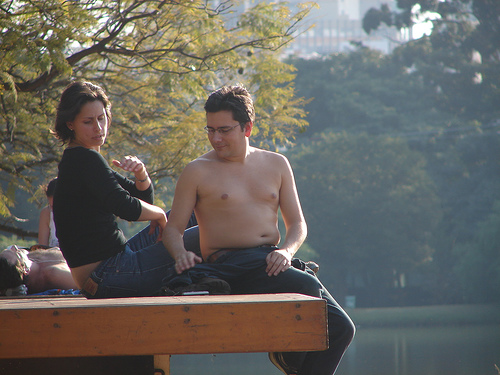

In [ ]:
pred1 = generate_desc(model1, tokenizer1, test_features1['1082379191_ec1e53f996'], max_length)
pred2 = generate_desc(model2, tokenizer2, test_features2['1082379191_ec1e53f996'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1082379191_ec1e53f996" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq two people are sitting on rock by body of water endseq
Second model:  startseq two boys are playing on gaurd rail endseq
Third model:  white dog is standing on the ground


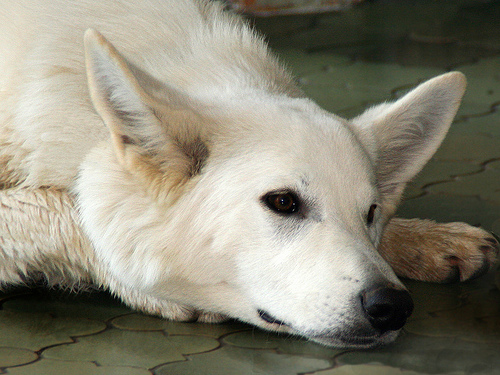

In [ ]:
pred1 = generate_desc(model1, tokenizer1, test_features1['1084040636_97d9633581'], max_length)
pred2 = generate_desc(model2, tokenizer2, test_features2['1084040636_97d9633581'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1084040636_97d9633581" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq two children are playing on gaurd rail endseq
Second model:  startseq two boys are playing on gaurd rail endseq
Third model:  little boy is playing with toy gun


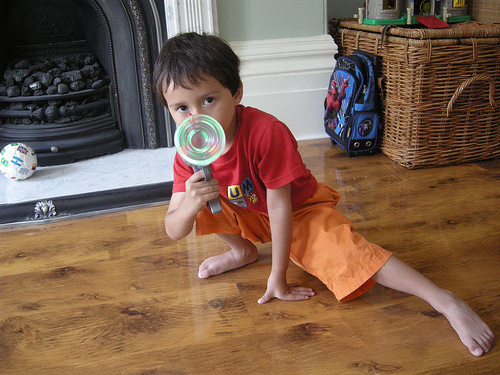

In [ ]:
pred1 = generate_desc(model1, tokenizer1, test_features1['1096395242_fc69f0ae5a'], max_length)
pred2 = generate_desc(model2, tokenizer2, test_features2['1096395242_fc69f0ae5a'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1096395242_fc69f0ae5a" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq two people are sitting on rock by body of water endseq
Second model:  startseq two boys are playing on gaurd rail endseq
Third model:  black dog is running through the grass


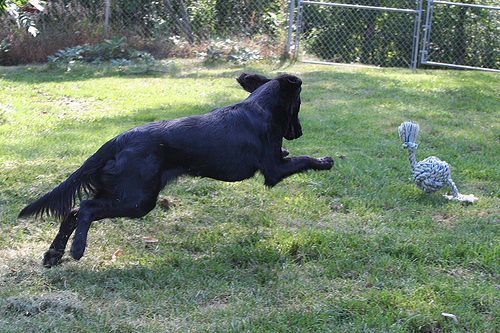

In [ ]:
pred1 = generate_desc(model1, tokenizer1, test_features1['1107246521_d16a476380'], max_length)
pred2 = generate_desc(model2, tokenizer2, test_features2['1107246521_d16a476380'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1107246521_d16a476380" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq two children are playing on bed endseq
Second model:  startseq two boys are playing on gaurd rail endseq
Third model:  little girl in pink dress is playing with toy


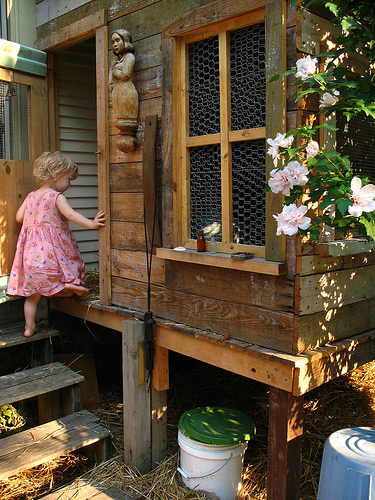

In [ ]:
pred1 = generate_desc(model1, tokenizer1, train1['1000268201_693b08cb0e'], max_length)
pred2 = generate_desc(model2, tokenizer2, train2['1000268201_693b08cb0e'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1000268201_693b08cb0e" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

#Results with forced new outputs for the CNN-RNN and VGG16-RNN model

Let's force the first two model to return the second choice of caption, and observe the results:

In [ ]:
# generate a description for an image
def generate_desc_force(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat2 = argmax(yhat[0])
		yhat[0][yhat2] = 0
		yhat2 = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat2, tokenizer)
		#print("word", word)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq young girl is jumping on bed near the ocean and she holds bottle endseq
Second model:  startseq man is climbing rock cliff with the sun beams endseq
Third model:  man and woman sit on bench


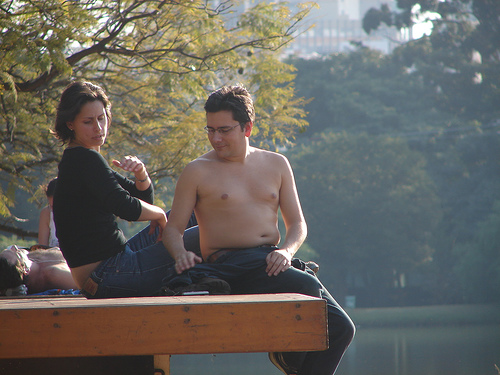

In [ ]:
pred1 = generate_desc_force(model1, tokenizer1, test_features1['1082379191_ec1e53f996'], max_length)
pred2 = generate_desc_force(model2, tokenizer2, test_features2['1082379191_ec1e53f996'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1082379191_ec1e53f996" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq man in kayak holding camera while boogie waves in the distance nearby of mountains and another watches in city the ground in city on the grass in the city on the beach
Second model:  startseq man is climbing rock cliff with the sun beams endseq
Third model:  white dog is standing on the ground


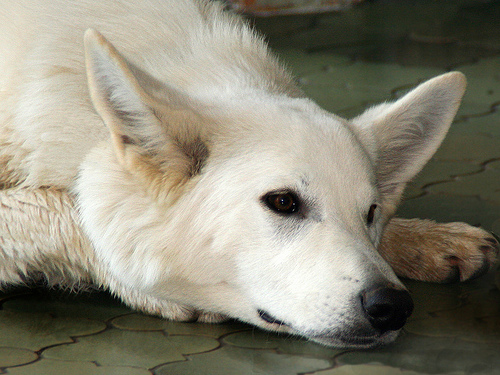

In [ ]:
pred1 = generate_desc_force(model1, tokenizer1, test_features1['1084040636_97d9633581'], max_length)
pred2 = generate_desc_force(model2, tokenizer2, test_features2['1084040636_97d9633581'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1084040636_97d9633581" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq young girl is blowing bubbles under an enclosed store range with person behind him in her living clothing and rafts bottle behind it and looks towards the father endseq
Second model:  startseq man is climbing rock cliff with the sun beams endseq
Third model:  little boy is playing with toy gun


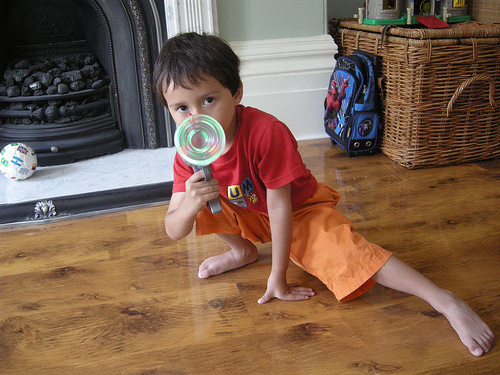

In [ ]:
pred1 = generate_desc_force(model1, tokenizer1, test_features1['1096395242_fc69f0ae5a'], max_length)
pred2 = generate_desc_force(model2, tokenizer2, test_features2['1096395242_fc69f0ae5a'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1096395242_fc69f0ae5a" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}



First model:  startseq man in kayak holding camera while boogie waves in the distance nearby of mountains and another watches in city the ground in city on the grass in the city on the beach
Second model:  startseq man is climbing rock cliff with the sun beams endseq
Third model:  black dog is running through the grass


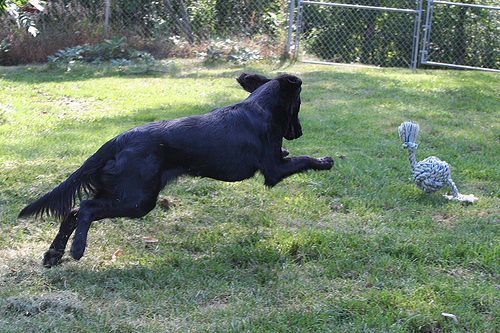

In [ ]:
pred1 = generate_desc_force(model1, tokenizer1, test_features1['1107246521_d16a476380'], max_length)
pred2 = generate_desc_force(model2, tokenizer2, test_features2['1107246521_d16a476380'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1107246521_d16a476380" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 50256,
  "eos_token_id": 50256,
  "pad_token_id": 50256,
  "transformers_version": "4.33.1"
}

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


First model:  startseq young girl wearing green dress and orange pants blowing pillow outdoors with her eyes hut is taking her finger in her hands whilst smiling at an event in square market and car
Second model:  startseq man is climbing rock cliff with the sun beams endseq
Third model:  little girl in pink dress is playing with toy


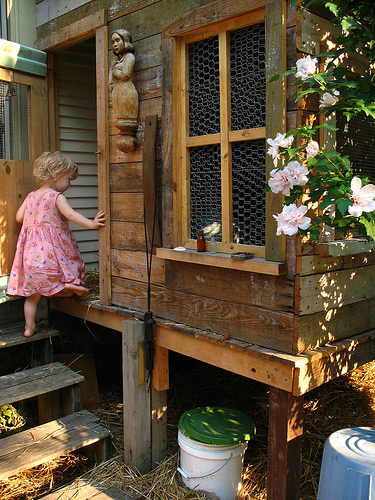

In [ ]:
pred1 = generate_desc_force(model1, tokenizer1, train1['1000268201_693b08cb0e'], max_length)
pred2 = generate_desc_force(model2, tokenizer2, train2['1000268201_693b08cb0e'], max_length)
directory_images=(valid_dataset[1]['filepath'].replace(valid_dataset[1]['filename'], '')) + "1000268201_693b08cb0e" +".jpg"
pred3=get_caption(best_model, image_processor, tokenizer3, directory_images)
image = Image.open(directory_images)
print("First model: ", pred1)
print("Second model: ", pred2)
print("Third model: ", pred3)
image